In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#no scientific notation
plt.style.use("fivethirtyeight")
plt.rcParams['figure.figsize'] = [25, 12]
plt.rcParams['font.size'] = 24
sns.set()
pd.set_option('display.float_format', lambda x: '%.1f' % x)
five_thirty_eight = [
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",
]

In [2]:
#cars = pd.read_csv("vehicles.csv")
cars = pd.read_csv("vehicles_na_cleaned.csv")

Looking at the data, some features might not be relevant for the analysis and I'll drop them so I don't have to load into memory redundant information. This should also decrease the size of the dataset on disk. I don't play to use any of these features in an initial analysis and eventually come back to them if the models aren't doing well at all.

In [ ]:
cars = cars.drop(columns=["id", "url", "VIN", "image_url", "county", "posting_date", "size"])

Some columns that have missing data, contain some information in the description column or in the model column. I'll try to backfill the data in case I will use these features later on.

In [ ]:
def backfill_column(x, column_name, values):
    if pd.notna(x[column_name]):
        return x[column_name]
    
    for value in values:        
        if value in str(x["description"]) or value in str(x["model"]):
            return value

In [ ]:
manufacturer = set(cars["manufacturer"].astype(str).unique())
fuel = set(cars["fuel"].astype(str).unique())
color = set(cars["paint_color"].astype(str).unique())
car_type = set(cars["type"].astype(str).unique())
cars["manufacturer"] = cars.apply(lambda x: backfill_column(x, "manufacturer", manufacturer), axis=1)
cars["fuel"] = cars.apply(lambda x: backfill_column(x, "fuel", fuel), axis=1)
cars["paint_color"] = cars.apply(lambda x: backfill_column(x, "paint_color", color), axis=1)
cars["type"] = cars.apply(lambda x: backfill_column(x, "type", car_type), axis=1)

In [ ]:
cars = cars.drop(columns=["model", "description"])
cars = cars.dropna(subset=["lat", "long", "odometer", "year", "fuel", "transmission", "manufacturer"])

In [ ]:
cars.to_csv("vehicles_na_cleaned.csv")

### What's the percentage of missing values for each feature ? 

In [3]:
nr_cars = len(cars)
cars.isna().sum()/nr_cars

Unnamed: 0     0.0
region         0.0
region_url     0.0
price          0.0
year           0.0
manufacturer   0.0
condition      0.4
cylinders      0.4
fuel           0.0
odometer       0.0
title_status   0.0
transmission   0.0
drive          0.3
type           0.2
paint_color    0.2
state          0.0
lat            0.0
long           0.0
dtype: float64

County seems to be a useless column so will drop this as well. Size also seems to be present in less than 30% of observations so again will drop this as well. 

Some ideas about the columns, and how I plan to use them:
- ~~year - there are so few observations missing year that might not even worth bothering so will check if we can drop those observations whatsoever~~
- ~~model - cleaning up this column might definitely be worth the effort, I'll just do some basic replacements and see if the number of unique values decreases. 
This still gives me around 15000 unique values, even if I tried to simply substring up to 10 characters and do some replacements. Will see if this is worth using as a feature.~~
- condition, 40% missing, will replace missing with "unspecified"
- cylinders, 40% missing, will replace missing with "unspecified"
- ~~fuel - will drop the 7% of observations that don't have fuel~~
- ~~odometer - I feel like this is going to be fairly good predictor so will just round them to the nears 10s. Went down to 66 unique values this way.~~
- title status, 20% missing, will replace missing with "unspecified"
- ~~transmission - will drop the records with missing values~~
- drive, 30% missing, replace missing with "unspecified"
- ~~size, 70% missing, don't consider it as a feature~~
- type, 20% missing, replace or drop 
- paint_color - 30% replace with unknown
- ~~lat/long - I could replace the lat/long with the coordinates of the state biggest city, but for now will drop the missing ones as they are just 1%~~

In [ ]:
cars["year"] = cars["year"].astype("int")
cars["lat"] = cars["lat"].astype("str")
cars["long"] = cars["long"].astype("str")

In [5]:
cars.describe()

,Unnamed: 0,price,year,odometer,lat,long
count,403481.0,403481.0,403481.0,403481.0,403481.0,403481.0
mean,212917.7,78693.4,2011.4,97052.6,38.5,-94.7
std,123258.5,12530533.8,9.1,203383.4,5.8,18.3
min,27.0,0.0,1900.0,0.0,-81.8,-159.8
25%,106252.0,5995.0,2008.0,37793.0,34.6,-111.9
50%,211966.0,13995.0,2014.0,85687.0,39.2,-88.4
75%,319384.0,26630.0,2017.0,133810.0,42.4,-80.9
max,426879.0,3736928711.0,2022.0,10000000.0,82.4,173.9


It looks like it's safe to drop everything that has a price over 100000 as the sample contains a negligeable number of observations with that price. There are also 26000 observations with the price 0. The hypothesis here is that these are probably cars that are either given out for free or just bad data. Will remove them as well.

In [6]:
len(cars[cars["price"] == 0])

26976

In [7]:
cars = cars[(cars["price"] < 100000) & (cars["price"] > 100)]

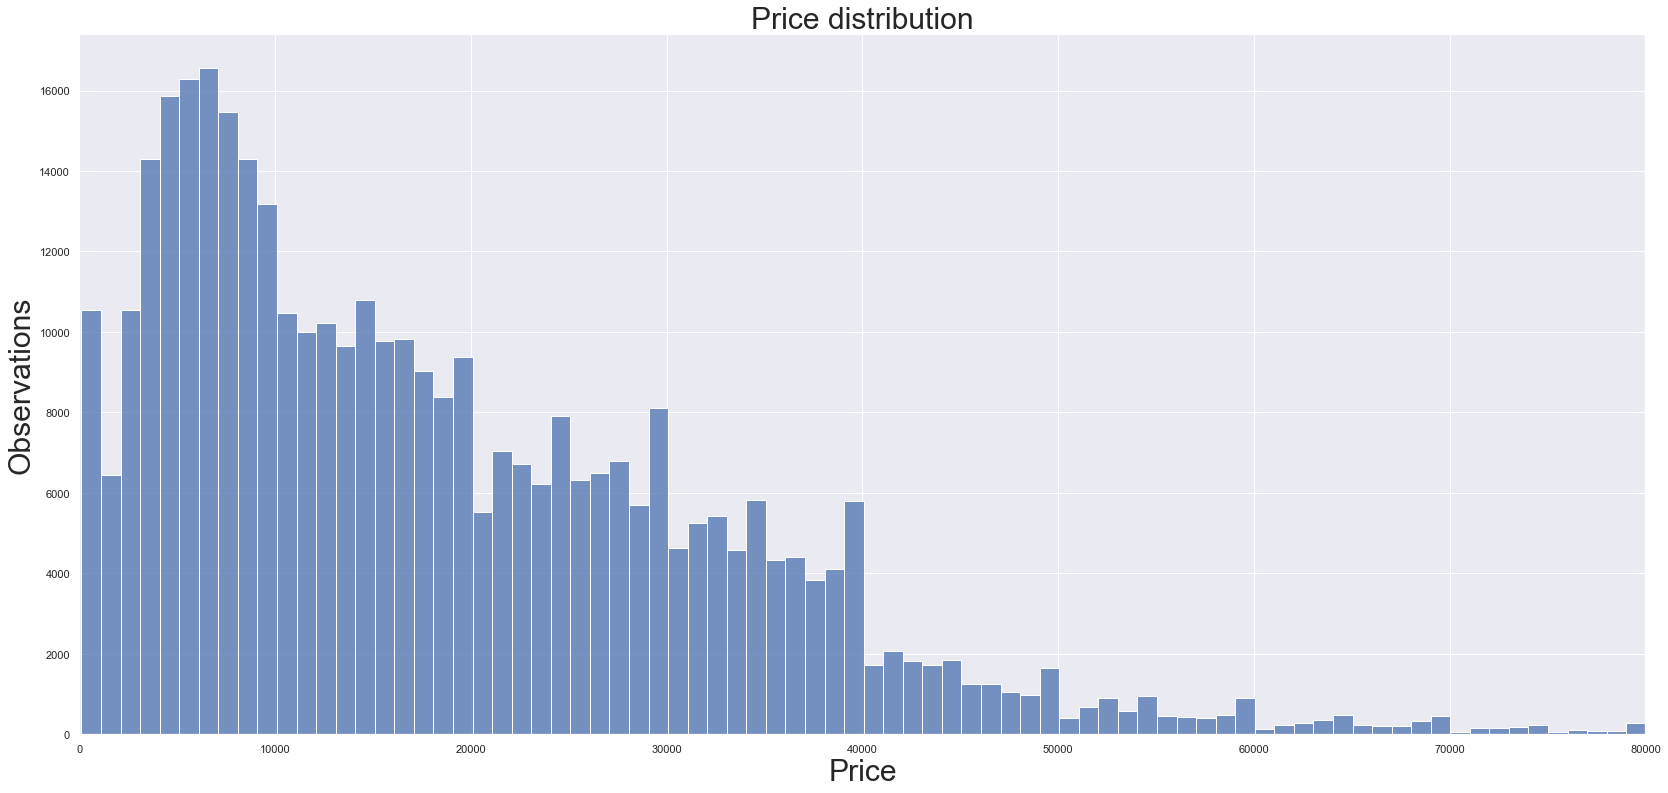

In [16]:
fig, ax = plt.subplots()
p = sns.histplot(cars["price"], bins=100)
p.axes.set_title("Price distribution",fontsize=30)
p.set_xlabel("Price",fontsize=30)
p.set_ylabel("Observations",fontsize=30)
plt.xlim([0, 80000])
ax.ticklabel_format(useOffset=False)
ax.ticklabel_format(style='plain')
plt.show()

#### Distribution of prices by existing properties

Text(0, 0.5, 'Density')

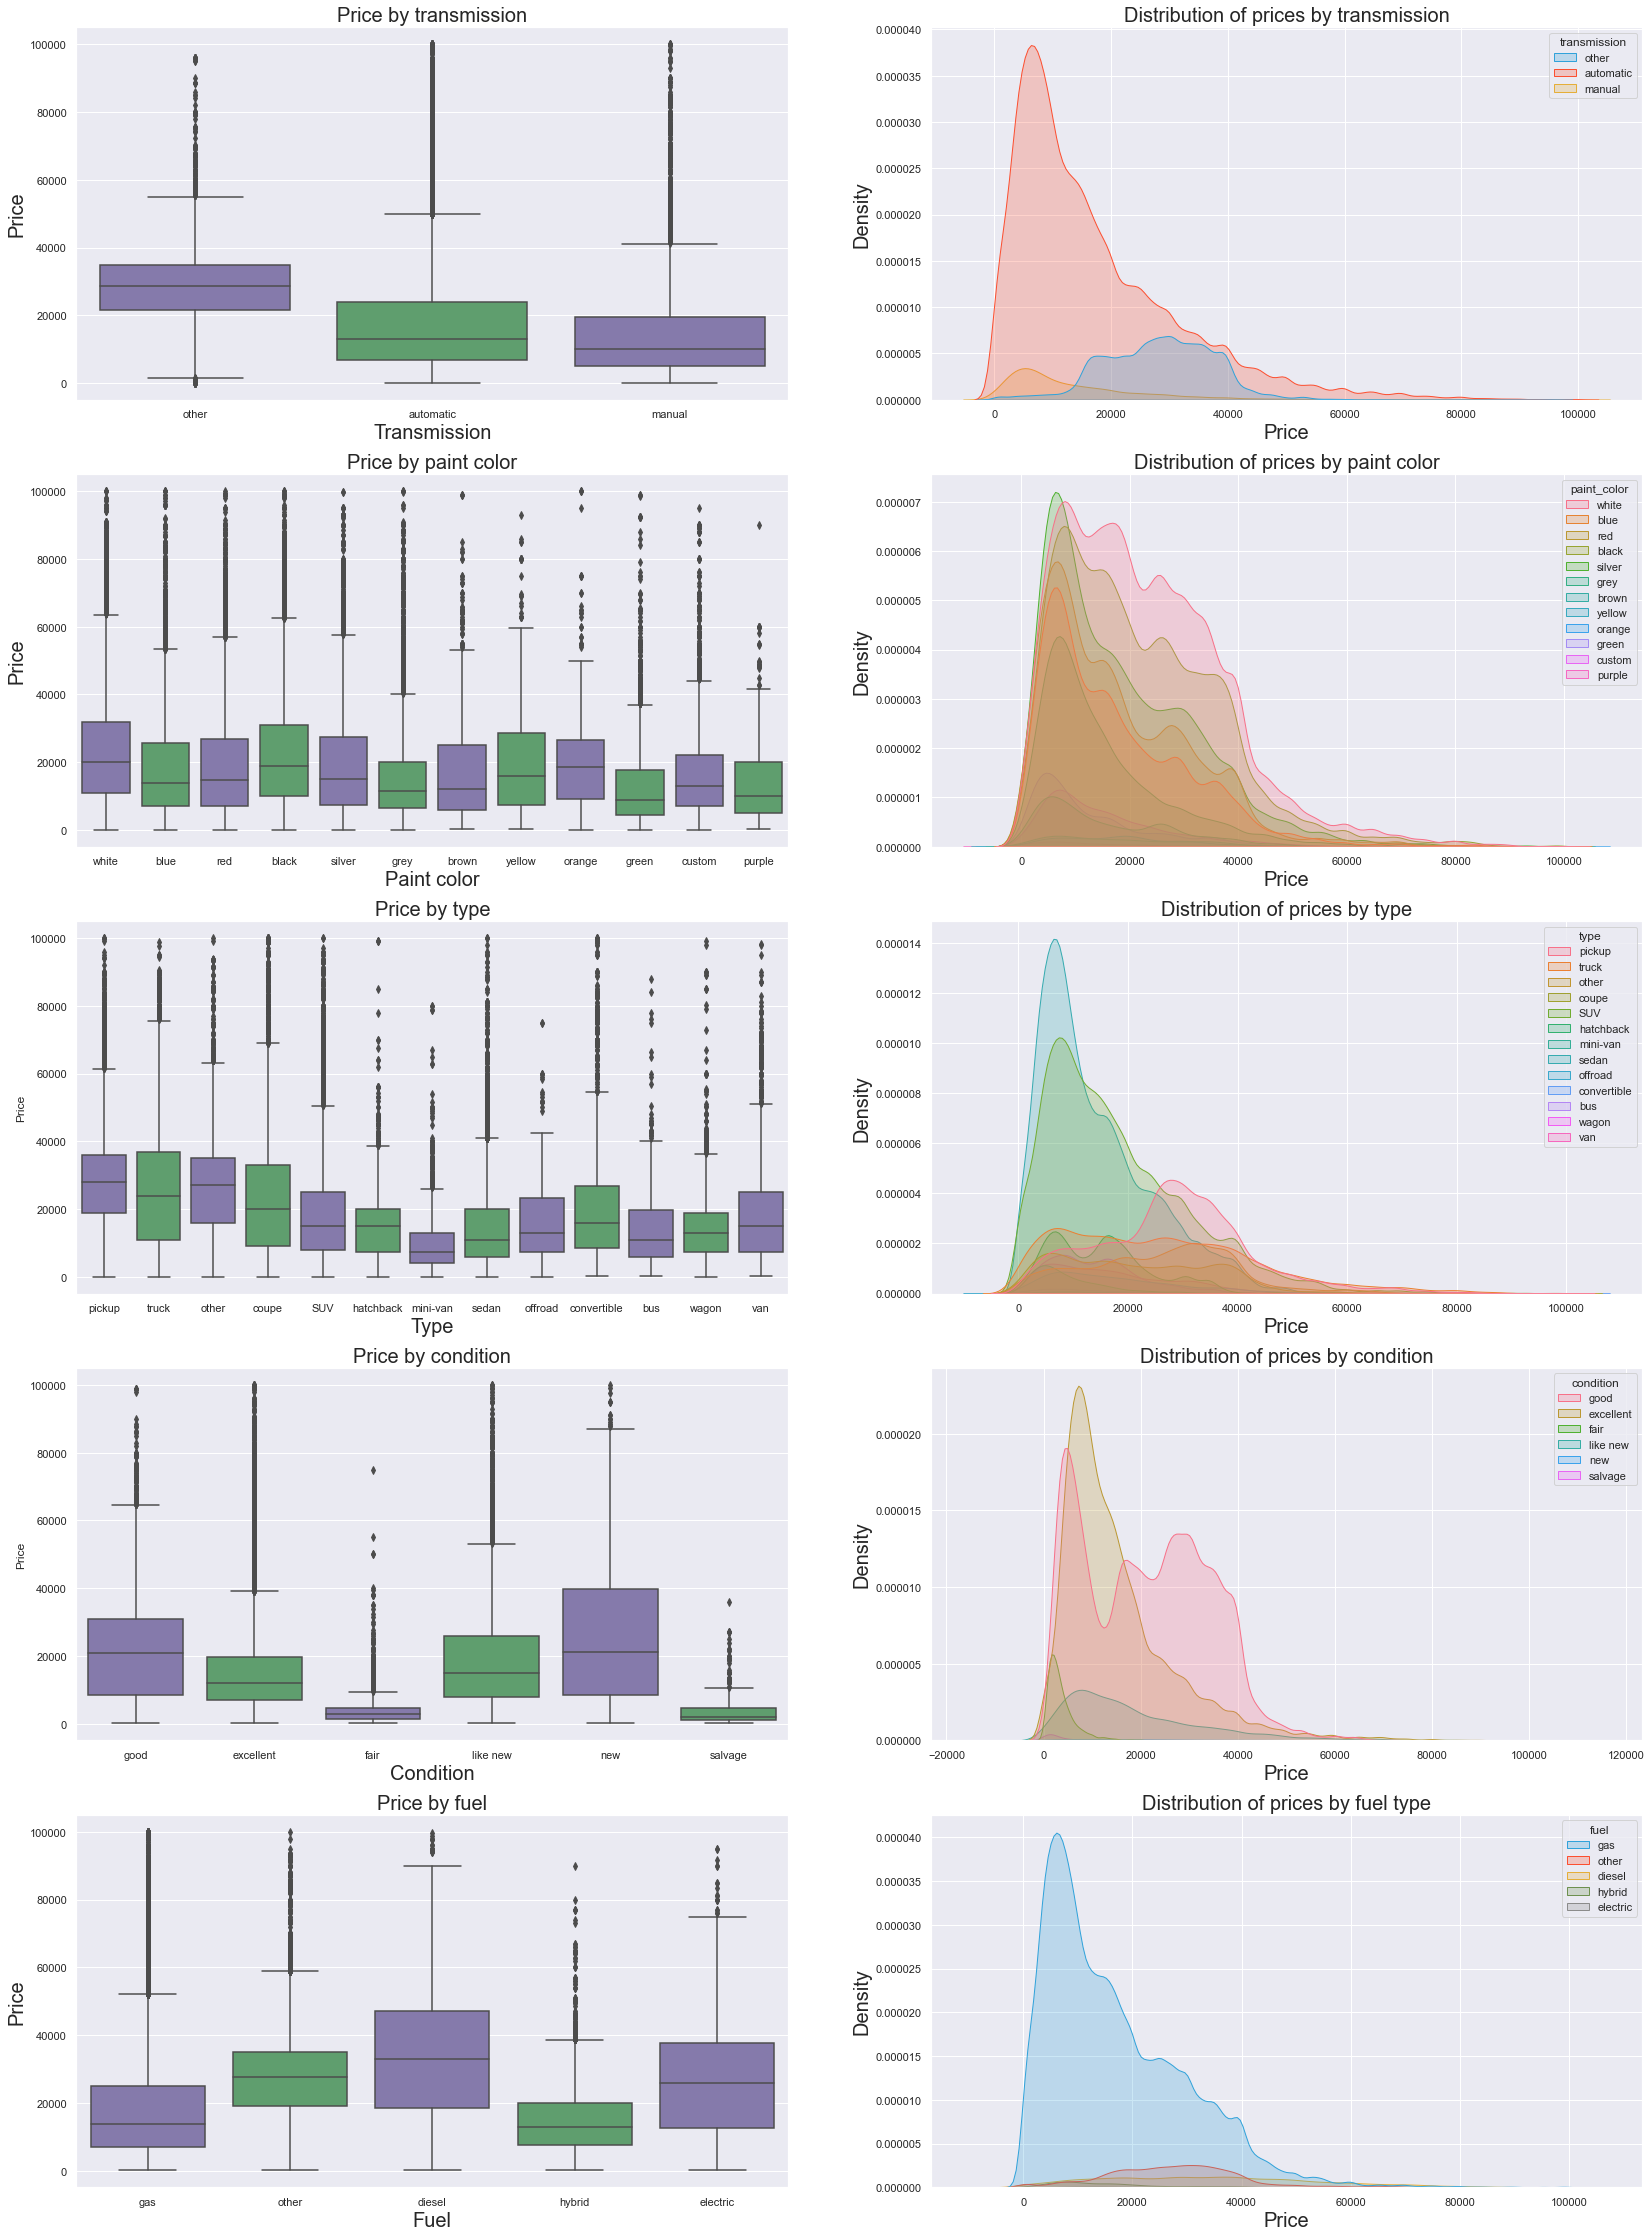

In [146]:
plt.subplot(5, 2, 1)
plt.subplots_adjust(bottom=5, top=7.5)
p = sns.boxplot(
    x="transmission", y="price", palette=["m", "g"],
    data=cars
)
p.set_title("Price by transmission", fontsize=20)
p.set_xlabel("Transmission", fontsize=20)
p.set_ylabel("Price", fontsize=20)
plt.subplot(5, 2, 2)
plt.ticklabel_format(style='plain', axis='y')
p = sns.kdeplot(x="price", hue="transmission", fill=True, common_norm=True, data=cars)
p.set_title("Distribution of prices by transmission", fontsize=20)
p.set_xlabel("Price", fontsize=20)
p.set_ylabel("Density", fontsize=20)


plt.subplot(5, 2, 3)
p = sns.boxplot(
    x="paint_color", y="price", palette=["m", "g"],
    data=cars
)
p.set_title("Price by paint color", fontsize=20)
p.set_xlabel("Paint color", fontsize=20)
p.set_ylabel("Price", fontsize=20)
plt.subplot(5, 2, 4)
plt.ticklabel_format(style='plain', axis='y')
p = sns.kdeplot(x="price", hue="paint_color", fill=True, data=cars)
p.set_title("Distribution of prices by paint color", fontsize=20)
p.set_xlabel("Price", fontsize=20)
p.set_ylabel("Density", fontsize=20)


plt.subplot(5, 2, 5)
p = sns.boxplot(
    x="type", y="price", palette=["m", "g"],
    data=cars
)
p.set_title("Price by type", fontsize=20)
p.set_xlabel("Type", fontsize=20)
p.set_ylabel("Price")
plt.subplot(5, 2, 6)
plt.ticklabel_format(style='plain', axis='y')
p = sns.kdeplot(x="price", hue="type", fill=True, data=cars)
p.set_title("Distribution of prices by type", fontsize=20)
p.set_xlabel("Price", fontsize=20)
p.set_ylabel("Density", fontsize=20)

plt.subplot(5, 2, 7)
p = sns.boxplot(
    x="condition", y="price", palette=["m", "g"],
    data=cars
)
p.set_title("Price by condition", fontsize=20)
p.set_xlabel("Condition", fontsize=20)
p.set_ylabel("Price")
plt.subplot(5, 2, 8)
plt.ticklabel_format(style='plain', axis='y')
p = sns.kdeplot(x="price", hue="condition", fill=True, common_norm=True, data=cars)
p.set_title("Distribution of prices by condition", fontsize=20)
p.set_xlabel("Price", fontsize=20)
p.set_ylabel("Density", fontsize=20)


plt.subplot(5, 2, 9)
p = sns.boxplot(
    x="fuel", y="price", palette=["m", "g"],
    data=cars
)
p.set_title("Price by fuel", fontsize=20)
p.set_xlabel("Fuel", fontsize=20)
p.set_ylabel("Price", fontsize=20)
plt.subplot(5, 2, 10)
plt.ticklabel_format(style='plain', axis='y')
p = sns.kdeplot(x="price", hue="fuel", fill=True, common_norm=True, data=cars)
p.set_title("Distribution of prices by fuel type", fontsize=20)
p.set_xlabel("Price", fontsize=20)
p.set_ylabel("Density", fontsize=20)



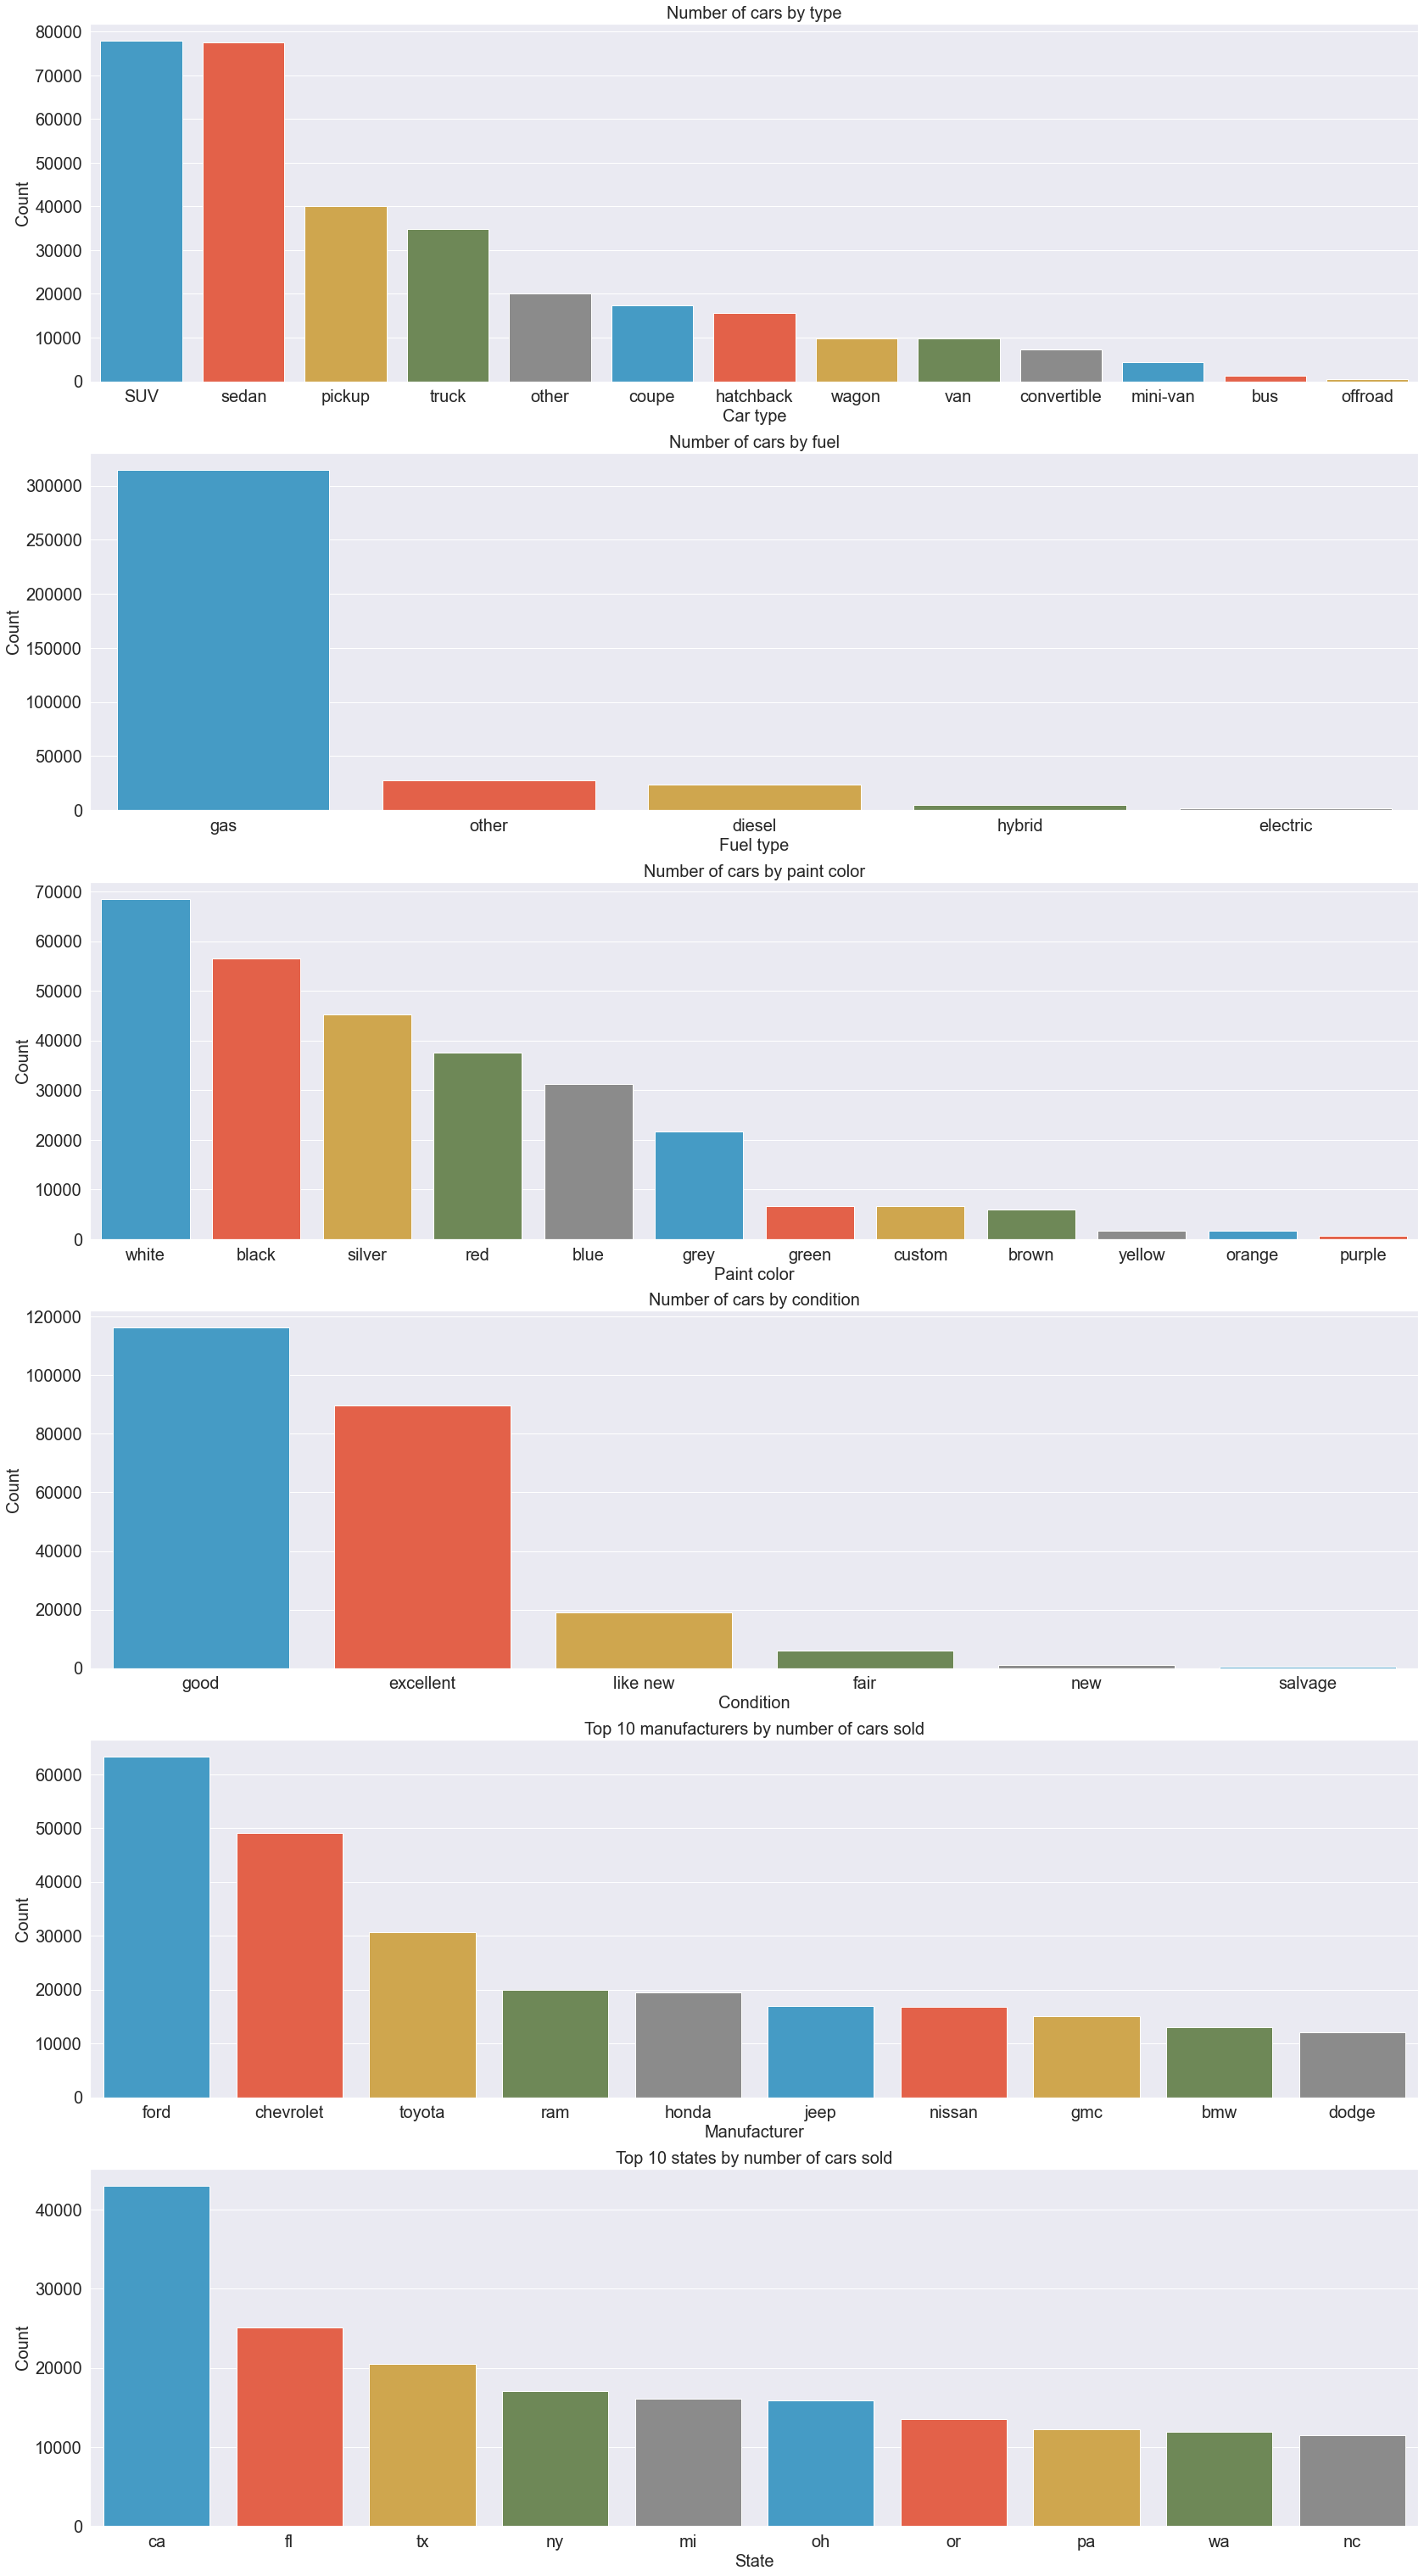

In [141]:
plt.subplots_adjust(bottom=4, top=8)
plt.subplot(7, 1, 1)
p = sns.countplot(
    x="type",
    order=cars["type"].value_counts().index,
    palette=five_thirty_eight,
    data=cars)
p.set_title("Number of cars by type", fontsize=20)
p.set_xlabel("Car type", fontsize=20)
p.set_ylabel("Count", fontsize=20)
p.tick_params(labelsize=20)

plt.subplot(7, 1, 2)
p = sns.countplot(
    x="fuel", 
    order=cars["fuel"].value_counts().index,
    palette=five_thirty_eight,
    data=cars)
p.set_title("Number of cars by fuel", fontsize=20)
p.set_xlabel("Fuel type", fontsize=20)
p.set_ylabel("Count", fontsize=20)
p.tick_params(labelsize=20)

plt.subplot(7, 1, 3)
p = sns.countplot(
    x="paint_color", 
    order=cars["paint_color"].value_counts().index,
    palette=five_thirty_eight,
    data=cars)
p.set_title("Number of cars by paint color", fontsize=20)
p.set_xlabel("Paint color", fontsize=20)
p.set_ylabel("Count", fontsize=20)
p.tick_params(labelsize=20)

plt.subplot(7, 1, 4)
p = sns.countplot(
    x="condition", 
    order=cars["condition"].value_counts().index,
    palette=five_thirty_eight,
    data=cars)
p.set_title("Number of cars by condition", fontsize=20)
p.set_xlabel("Condition", fontsize=20)
p.set_ylabel("Count", fontsize=20)
p.tick_params(labelsize=20)

plt.subplot(7, 1, 5)
p = sns.countplot(
    x="manufacturer", 
    order=cars["manufacturer"].value_counts().iloc[:10].index,
    palette=five_thirty_eight,
    data=cars)
p.set_title("Top 10 manufacturers by number of cars sold", fontsize=20)
p.set_xlabel("Manufacturer", fontsize=20)
p.set_ylabel("Count", fontsize=20)
p.tick_params(labelsize=20)

plt.subplot(7, 1, 6)
p = sns.countplot(
    x="state", 
    order=cars["state"].value_counts().iloc[:10].index,
    palette=five_thirty_eight,
    data=cars)
p.set_title("Top 10 states by number of cars sold", fontsize=20)
p.set_xlabel("State", fontsize=20)
p.set_ylabel("Count", fontsize=20)
p.tick_params(labelsize=20)

In [10]:
cars

,Unnamed: 0,region,region_url,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long
0,27,auburn,https://auburn.craigslist.org,33590,2014.0,gmc,good,8 cylinders,gas,57923.0,clean,other,NaN,pickup,white,al,32.6,-85.5
1,28,auburn,https://auburn.craigslist.org,22590,2010.0,chevrolet,good,8 cylinders,gas,71229.0,clean,other,NaN,pickup,blue,al,32.6,-85.5
2,29,auburn,https://auburn.craigslist.org,39590,2020.0,chevrolet,good,8 cylinders,gas,19160.0,clean,other,NaN,pickup,red,al,32.6,-85.5
3,30,auburn,https://auburn.craigslist.org,30990,2017.0,toyota,good,8 cylinders,gas,41124.0,clean,other,NaN,pickup,red,al,32.6,-85.5
4,31,auburn,https://auburn.craigslist.org,15000,2013.0,ford,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,black,al,32.6,-85.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403476,426875,wyoming,https://wyoming.craigslist.org,23590,2019.0,nissan,good,6 cylinders,gas,32226.0,clean,other,fwd,sedan,NaN,wy,33.8,-84.4
403477,426876,wyoming,https://wyoming.craigslist.org,30590,2020.0,volvo,good,NaN,gas,12029.0,clean,other,fwd,sedan,red,wy,33.8,-84.4
403478,426877,wyoming,https://wyoming.craigslist.org,34990,2020.0,cadillac,good,NaN,diesel,4174.0,clean,other,NaN,hatchback,white,wy,33.8,-84.4
403479,426878,wyoming,https://wyoming.craigslist.org,28990,2018.0,lexus,good,6 cylinders,gas,30112.0,clean,other,fwd,sedan,silver,wy,33.8,-84.4
